In [1]:
!pip -q install pandas numpy matplotlib scikit-learn scipy tensorflow

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

from scipy.signal import butter, filtfilt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TF:", tf.__version__)


2025-12-16 12:19:06.041638: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-16 12:19:06.096142: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-16 12:19:08.004349: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TF: 2.20.0


In [2]:
PARAMS = {
    # Window / Sampling
    "FS": 128,
    "PRE_S": 0.25,
    "POST_S": 0.45,

    # Filter
    "BP_LOW": 0.5,
    "BP_HIGH": 40.0,
    "BP_ORDER": 4,

    # Split
    "RANDOM_STATE": 42,
    "TEST_SIZE": 0.30,
    "VAL_FROM_TMP": 0.50,

    # Training
    "LR": 1e-3,
    "BATCH": 64,
    "EPOCHS": 50,
    "EARLYSTOP_PATIENCE": 8,
    "REDUCE_PATIENCE": 4,
    "REDUCE_FACTOR": 0.5,
    "MIN_LR": 1e-5,

    # Model
    "C1_F": 32,  "C1_K": 7,
    "C2_F": 64,  "C2_K": 5,
    "C3_F": 128, "C3_K": 3,
    "DROP_SIG": 0.30,
    "RR_DENSE": 16,
    "DROP_RR": 0.20,
    "FUSE_DENSE": 64,
    "DROP_FUSE": 0.30,

    # Optional
    "CW_CAP": None,  # ör: 15.0
    "THR_RULE": "best_f1",  # "best_f1" veya "min_recall=1.0"
    "NOTES": ""
}

display(pd.DataFrame([PARAMS]).T.rename(columns={0:"value"}))


,value
FS,128
PRE_S,0.25
POST_S,0.45
BP_LOW,0.5
BP_HIGH,40.0
BP_ORDER,4
RANDOM_STATE,42
TEST_SIZE,0.3
VAL_FROM_TMP,0.5
LR,0.001


In [3]:
RUNS = []

def log_run(task, metrics: dict, extra_params: dict=None):
    row = {"task": task}
    for k,v in PARAMS.items():
        row[f"p__{k}"] = v
    if extra_params:
        for k,v in extra_params.items():
            row[f"p__{k}"] = v
    for k,v in metrics.items():
        row[f"m__{k}"] = v

    RUNS.append(row)
    df = pd.DataFrame(RUNS)
    display(df)
    return df


In [20]:
EKG_CSV = "Dataset/800_ekg.csv"
ANN_CSV = "Dataset/800_annotations.csv"

assert os.path.exists(EKG_CSV), f"Missing {EKG_CSV}"
assert os.path.exists(ANN_CSV), f"Missing {ANN_CSV}"

ekg = pd.read_csv(EKG_CSV)
ann = pd.read_csv(ANN_CSV)
ekg.columns = [c.strip() for c in ekg.columns]
ann.columns = [c.strip() for c in ann.columns]

print("ekg:", ekg.shape, "ann:", ann.shape)
display(ekg.head())
display(ann.head())


ekg: (230400, 4) ann: (1921, 2)


,Unnamed: 0,ECG1,ECG2,annotation
0,0,-0.505,0.615,NaN
1,1,-0.495,0.755,NaN
2,2,-0.545,0.805,NaN
3,3,-0.445,0.865,NaN
4,4,-0.275,0.815,NaN


,Unnamed: 0,symbol
0,162,N
1,330,N
2,497,N
3,666,N
4,836,N


In [5]:
# symbol col
sym_col = None
for c in ann.columns:
    if c.lower() in {"symbol","annotation","label"}:
        sym_col = c
        break
if sym_col is None:
    sym_col = ann.columns[-1]

# index col
idx_col = None
for c in ann.columns:
    if c == sym_col:
        continue
    if ("unnamed" in c.lower()) or ("index" in c.lower()) or ("sample" in c.lower()) or ("point" in c.lower()):
        idx_col = c
        break
if idx_col is None:
    idx_col = [c for c in ann.columns if c != sym_col][0]

ann2 = ann[[idx_col, sym_col]].rename(columns={idx_col:"sample_index", sym_col:"symbol"})
ann2["sample_index"] = ann2["sample_index"].astype(int)
ann2["symbol"] = ann2["symbol"].astype(str)

# lead cols
lead_cols = [c for c in ekg.columns if c.lower() in {"ecg1","ecg2","lead1","lead2"}]
if len(lead_cols) < 2:
    candidates = [c for c in ekg.columns if not c.lower().startswith("unnamed")]
    num_candidates = [c for c in candidates if pd.api.types.is_numeric_dtype(ekg[c])]
    lead_cols = num_candidates[:2]
lead_cols = lead_cols[:2]

print("idx_col:", idx_col, "sym_col:", sym_col)
print("lead_cols:", lead_cols)
print("raw symbols:\n", ann2["symbol"].value_counts())
display(ann2.head())


idx_col: Unnamed: 0 sym_col: symbol
lead_cols: ['ECG1', 'ECG2']
raw symbols:
 symbol
N    1846
S      30
~      28
|      10
V       6
F       1
Name: count, dtype: int64


,sample_index,symbol
0,162,N
1,330,N
2,497,N
3,666,N
4,836,N


In [6]:
def bandpass(x, fs):
    low, high, order = PARAMS["BP_LOW"], PARAMS["BP_HIGH"], PARAMS["BP_ORDER"]
    ny = 0.5 * fs
    b, a = butter(order, [low/ny, high/ny], btype="band")
    return filtfilt(b, a, x)

def make_windows(ekg_df, ann_df, lead_cols):
    fs = PARAMS["FS"]
    pre_s, post_s = PARAMS["PRE_S"], PARAMS["POST_S"]

    sig = ekg_df[lead_cols].values.astype(np.float32)

    sig_f = np.zeros_like(sig)
    for ch in range(sig.shape[1]):
        sig_f[:, ch] = bandpass(sig[:, ch], fs=fs)

    a = ann_df.copy().sort_values("sample_index")
    pre  = int(round(pre_s * fs))
    post = int(round(post_s * fs))
    L = pre + post + 1

    idx = a["sample_index"].values

    rr_prev = np.diff(idx, prepend=idx[0]).astype(np.float32) / fs
    rr_next = np.diff(idx, append=idx[-1]).astype(np.float32) / fs
    rr_ratio = np.divide(rr_prev, rr_next, out=np.ones_like(rr_prev), where=rr_next!=0)

    X, R, sym = [], [], []
    for i, sidx in enumerate(idx):
        start = sidx - pre
        end   = sidx + post
        if start < 0 or end >= len(sig_f):
            continue
        X.append(sig_f[start:end+1, :])
        R.append([rr_prev[i], rr_next[i], rr_ratio[i]])
        sym.append(a.iloc[i]["symbol"])

    X = np.stack(X).astype(np.float32)
    R = np.array(R, dtype=np.float32)
    sym = np.array(sym)
    return X, R, sym, L


In [7]:
SVEB_POS = {"S","A","a","J"}
DROP_SYMS = {"~","|"}  # binary SVEB'de bunları kullanmıyoruz

TASK_PARAMS = {
    "SVEB_POS": sorted(list(SVEB_POS)),
    "DROP_SYMS": sorted(list(DROP_SYMS)),
}

X, R, sym_raw, L = make_windows(ekg, ann2, lead_cols)

mask = ~pd.Series(sym_raw).isin(DROP_SYMS).values
Xb, Rb, symb = X[mask], R[mask], sym_raw[mask]

y = np.array([1 if s in SVEB_POS else 0 for s in symb], dtype=np.int32)

print("X:", Xb.shape, "R:", Rb.shape, "L:", L)
print("symbols:\n", pd.Series(symb).value_counts())
print("binary labels:\n", pd.Series(y).value_counts())


X: (1883, 91, 2) R: (1883, 3) L: 91
symbols:
 N    1846
S      30
V       6
F       1
Name: count, dtype: int64
binary labels:
 0    1853
1      30
Name: count, dtype: int64


In [8]:
X_train, X_tmp, R_train, R_tmp, y_train, y_tmp = train_test_split(
    Xb, Rb, y,
    test_size=PARAMS["TEST_SIZE"],
    random_state=PARAMS["RANDOM_STATE"],
    stratify=y
)

X_val, X_test, R_val, R_test, y_val, y_test = train_test_split(
    X_tmp, R_tmp, y_tmp,
    test_size=PARAMS["VAL_FROM_TMP"],
    random_state=PARAMS["RANDOM_STATE"],
    stratify=y_tmp
)

print("Train pos:", int(y_train.sum()), "Val pos:", int(y_val.sum()), "Test pos:", int(y_test.sum()))


Train pos: 21 Val pos: 4 Test pos: 5


In [9]:
classes = np.array([0,1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {0: float(cw[0]), 1: float(cw[1])}

if PARAMS["CW_CAP"] is not None:
    class_weight = {k: min(v, float(PARAMS["CW_CAP"])) for k,v in class_weight.items()}

print("class_weight:", class_weight)

def build_model(input_len, n_channels=2):
    x_in = keras.Input(shape=(input_len, n_channels), name="signal")

    x = layers.Conv1D(PARAMS["C1_F"], PARAMS["C1_K"], padding="same", activation="relu")(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)

    x = layers.Conv1D(PARAMS["C2_F"], PARAMS["C2_K"], padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)

    x = layers.Conv1D(PARAMS["C3_F"], PARAMS["C3_K"], padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(PARAMS["DROP_SIG"])(x)

    rr_in = keras.Input(shape=(3,), name="rr")
    r = layers.Dense(PARAMS["RR_DENSE"], activation="relu")(rr_in)
    r = layers.Dropout(PARAMS["DROP_RR"])(r)

    h = layers.Concatenate()([x, r])
    h = layers.Dense(PARAMS["FUSE_DENSE"], activation="relu")(h)
    h = layers.Dropout(PARAMS["DROP_FUSE"])(h)

    out = layers.Dense(1, activation="sigmoid")(h)

    model = keras.Model(inputs=[x_in, rr_in], outputs=out)
    model.compile(
        optimizer=keras.optimizers.Adam(PARAMS["LR"]),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.AUC(name="roc_auc", curve="ROC"),
            keras.metrics.AUC(name="pr_auc", curve="PR"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ]
    )
    return model

model = build_model(input_len=L, n_channels=2)
model.summary()


class_weight: {0: 0.5080956052428681, 1: 31.38095238095238}


2025-12-16 12:19:08.607445: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ signal (InputLayer) │ (None, 91, 2)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 91, 32)    │        480 │ signal[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 91, 32)    │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 45, 32)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 45, 64)    │     10,304 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 22, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 22, 128)   │     24,704 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 128)   │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rr (InputLayer)     │ (None, 3)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │         64 │ rr[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 144)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      9,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,793 (178.88 KB)

 Trainable params: 45,345 (177.13 KB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_pr_auc", mode="max",
                                  patience=PARAMS["EARLYSTOP_PATIENCE"], restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_pr_auc", mode="max",
                                      patience=PARAMS["REDUCE_PATIENCE"],
                                      factor=PARAMS["REDUCE_FACTOR"],
                                      min_lr=PARAMS["MIN_LR"]),
]

history = model.fit(
    {"signal": X_train, "rr": R_train}, y_train,
    validation_data=({"signal": X_val, "rr": R_val}, y_val),
    epochs=PARAMS["EPOCHS"],
    batch_size=PARAMS["BATCH"],
    class_weight=class_weight,
    verbose=1
)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.6542 - pr_auc: 0.0337 - precision: 0.0249 - recall: 0.5238 - roc_auc: 0.6620 - val_loss: 0.5828 - val_pr_auc: 0.3005 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.9856
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4916 - pr_auc: 0.2143 - precision: 0.0429 - recall: 0.8571 - roc_auc: 0.8741 - val_loss: 0.4722 - val_pr_auc: 0.3292 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.9874
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.4010 - pr_auc: 0.3322 - precision: 0.0881 - recall: 0.9524 - roc_auc: 0.9451 - val_loss: 0.3163 - val_pr_auc: 0.3146 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.9865
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2957 - pr_auc: 0.5354 - precision: 0.1005 - recall: 0.9524 - roc_auc: 0.9673 - val_loss: 0.1684 - val_pr_auc: 0.3209 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_

In [11]:
proba = model.predict({"signal": X_test, "rr": R_test}).ravel()

roc = roc_auc_score(y_test, proba) if len(np.unique(y_test)) > 1 else np.nan
pr  = average_precision_score(y_test, proba) if len(np.unique(y_test)) > 1 else np.nan

prec, rec, thr = precision_recall_curve(y_test, proba)
thr_full = np.r_[thr, thr[-1] if len(thr) else 0.5]

if PARAMS["THR_RULE"] == "best_f1":
    f1s = 2*prec*rec/(prec+rec+1e-12)
    i = int(np.argmax(f1s))
    best_thr = float(thr_full[i])
elif PARAMS["THR_RULE"].startswith("min_recall"):
    # ör: "min_recall=1.0"
    min_rec = float(PARAMS["THR_RULE"].split("=")[1])
    mask = rec >= min_rec
    if not np.any(mask):
        best_thr = 0.5
    else:
        i = int(np.argmax(np.where(mask, prec, -1)))
        best_thr = float(thr_full[i])
else:
    best_thr = 0.5

y_pred = (proba >= best_thr).astype(int)

print("Test ROC-AUC:", roc)
print("Test PR-AUC :", pr)
print("Best thr:", best_thr)
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

metrics = {
    "roc_auc": float(roc),
    "pr_auc": float(pr),
    "thr": float(best_thr),
    "precision": float(precision_score(y_test, y_pred, zero_division=0)),
    "recall": float(recall_score(y_test, y_pred, zero_division=0)),
    "f1": float(f1_score(y_test, y_pred, zero_division=0)),
    "tp": int(((y_pred==1)&(y_test==1)).sum()),
    "fp": int(((y_pred==1)&(y_test==0)).sum()),
    "fn": int(((y_pred==0)&(y_test==1)).sum()),
}

log_run("SVEB_binary", metrics, extra_params=TASK_PARAMS)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test ROC-AUC: 0.9949640287769784
Test PR-AUC : 0.6683333333333333
Best thr: 0.6521931290626526
              precision    recall  f1-score   support

           0     0.9964    0.9964    0.9964       278
           1     0.8000    0.8000    0.8000         5

    accuracy                         0.9929       283
   macro avg     0.8982    0.8982    0.8982       283
weighted avg     0.9929    0.9929    0.9929       283

Confusion matrix:
 [[277   1]
 [  1   4]]


,task,p__FS,p__PRE_S,p__POST_S,p__BP_LOW,p__BP_HIGH,p__BP_ORDER,p__RANDOM_STATE,p__TEST_SIZE,p__VAL_FROM_TMP,...,p__DROP_SYMS,m__roc_auc,m__pr_auc,m__thr,m__precision,m__recall,m__f1,m__tp,m__fp,m__fn
0,SVEB_binary,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,"[|, ~]",0.994964,0.668333,0.652193,0.8,0.8,0.8,4,1,1


,task,p__FS,p__PRE_S,p__POST_S,p__BP_LOW,p__BP_HIGH,p__BP_ORDER,p__RANDOM_STATE,p__TEST_SIZE,p__VAL_FROM_TMP,...,p__DROP_SYMS,m__roc_auc,m__pr_auc,m__thr,m__precision,m__recall,m__f1,m__tp,m__fp,m__fn
0,SVEB_binary,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,"[|, ~]",0.994964,0.668333,0.652193,0.8,0.8,0.8,4,1,1


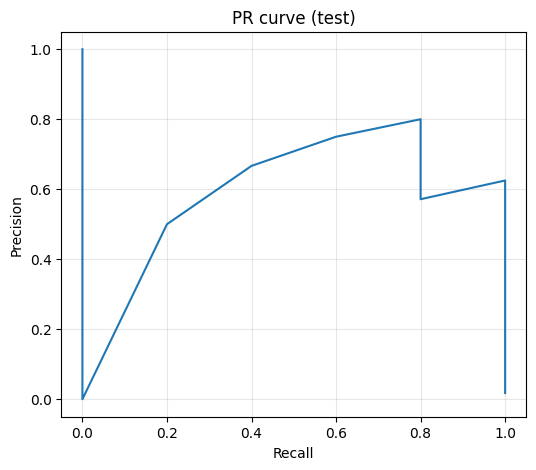

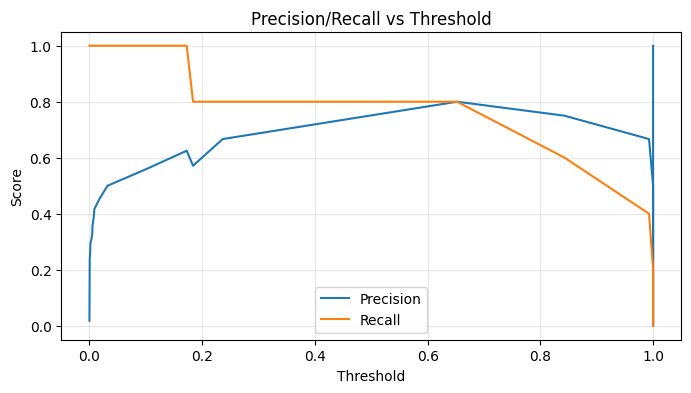

In [12]:
plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.grid(True, alpha=0.3)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("PR curve (test)")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(thr_full, prec, label="Precision")
plt.plot(thr_full, rec, label="Recall")
plt.grid(True, alpha=0.3)
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title("Precision/Recall vs Threshold")
plt.legend()
plt.show()


,loss,pr_auc,precision,recall,roc_auc,val_loss,val_pr_auc,val_precision,val_recall,val_roc_auc
45,0.001846,1.0,0.954545,1.0,1.0,0.002046,1.0,1.0,1.0,1.0
46,0.001836,1.0,1.000000,1.0,1.0,0.001875,1.0,1.0,1.0,1.0
47,0.001894,1.0,0.954545,1.0,1.0,0.001901,1.0,1.0,1.0,1.0
48,0.001589,1.0,1.000000,1.0,1.0,0.002665,1.0,1.0,1.0,1.0
49,0.001147,1.0,1.000000,1.0,1.0,0.001836,1.0,1.0,1.0,1.0


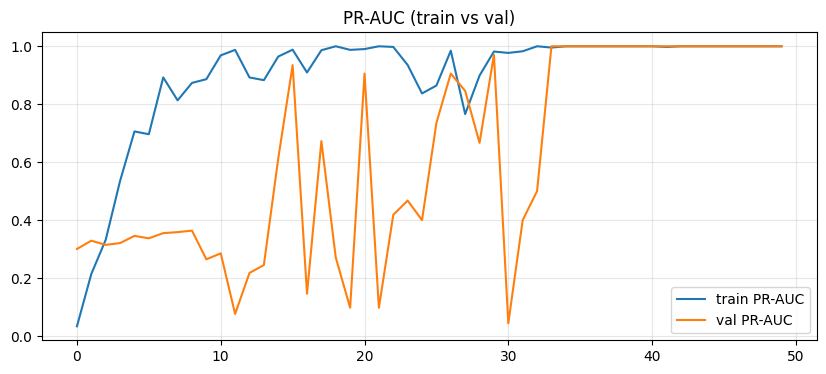

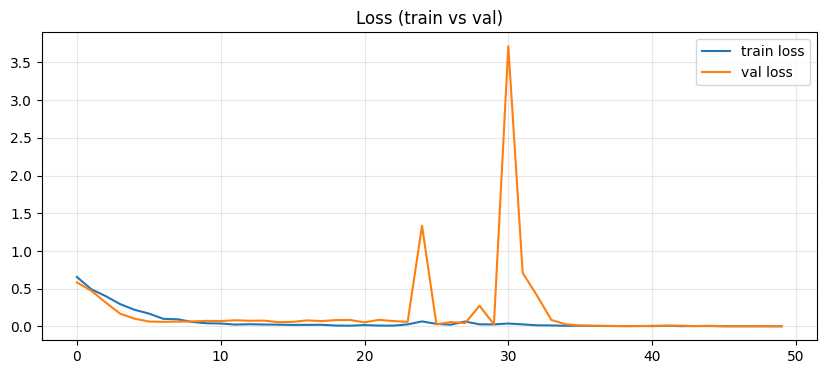

In [13]:
hist = pd.DataFrame(history.history)
display(hist.tail())

plt.figure(figsize=(10,4))
plt.plot(hist["pr_auc"], label="train PR-AUC")
plt.plot(hist["val_pr_auc"], label="val PR-AUC")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("PR-AUC (train vs val)")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(hist["loss"], label="train loss")
plt.plot(hist["val_loss"], label="val loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("Loss (train vs val)")
plt.show()


In [14]:
proba_tr = model.predict({"signal": X_train, "rr": R_train}).ravel()
roc_tr = roc_auc_score(y_train, proba_tr) if len(np.unique(y_train)) > 1 else np.nan
pr_tr  = average_precision_score(y_train, proba_tr) if len(np.unique(y_train)) > 1 else np.nan

proba_va = model.predict({"signal": X_val, "rr": R_val}).ravel()
roc_va = roc_auc_score(y_val, proba_va) if len(np.unique(y_val)) > 1 else np.nan
pr_va  = average_precision_score(y_val, proba_va) if len(np.unique(y_val)) > 1 else np.nan

print("Train ROC:", roc_tr, "Train PR:", pr_tr)
print("Val   ROC:", roc_va, "Val   PR:", pr_va)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train ROC: 1.0 Train PR: 1.0000000000000002
Val   ROC: 1.0 Val   PR: 1.0


In [15]:
import numpy as np

def make_features(X, R, add_stats=True):
    # X: (n, L, 2), R: (n, 3)
    n, L, C = X.shape
    flat = X.reshape(n, L*C)

    feats = [flat, R]

    if add_stats:
        # kanal bazlı basit istatistikler (baseline'ları ciddi güçlendirir)
        # mean/std/min/max (2 kanal -> 8 özellik)
        mean = X.mean(axis=1)
        std  = X.std(axis=1)
        mn   = X.min(axis=1)
        mx   = X.max(axis=1)
        stats = np.concatenate([mean, std, mn, mx], axis=1)
        feats.append(stats)

    return np.concatenate(feats, axis=1).astype(np.float32)

Xtr_f = make_features(X_train, R_train, add_stats=True)
Xva_f = make_features(X_val,   R_val,   add_stats=True)
Xte_f = make_features(X_test,  R_test,  add_stats=True)

print("Feature shapes:", Xtr_f.shape, Xva_f.shape, Xte_f.shape)


Feature shapes: (1318, 193) (282, 193) (283, 193)


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, precision_score, recall_score, f1_score,
    confusion_matrix
)

def eval_binary_proba(y_true, proba, thr_rule="best_f1", min_recall=1.0):
    roc = roc_auc_score(y_true, proba) if len(np.unique(y_true)) > 1 else np.nan
    pr  = average_precision_score(y_true, proba) if len(np.unique(y_true)) > 1 else np.nan

    prec, rec, thr = precision_recall_curve(y_true, proba)
    thr_full = np.r_[thr, thr[-1] if len(thr) else 0.5]

    if thr_rule == "best_f1":
        f1s = 2*prec*rec/(prec+rec+1e-12)
        i = np.argmax(f1s)
        best_thr = float(thr_full[i])
    elif thr_rule.startswith("min_recall"):
        # min_recall=1.0 gibi
        mask = rec >= min_recall
        if not np.any(mask):
            best_thr = 0.5
        else:
            i = np.argmax(np.where(mask, prec, -1))
            best_thr = float(thr_full[i])
    else:
        best_thr = 0.5

    y_pred = (proba >= best_thr).astype(int)

    metrics = {
        "roc_auc": float(roc),
        "pr_auc": float(pr),
        "thr": float(best_thr),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "tp": int(((y_pred==1)&(y_true==1)).sum()),
        "fp": int(((y_pred==1)&(y_true==0)).sum()),
        "fn": int(((y_pred==0)&(y_true==1)).sum()),
    }
    return metrics, confusion_matrix(y_true, y_pred)

def run_binary_model(name, clf, Xtr, ytr, Xte, yte, thr_rule="best_f1"):
    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)

    clf.fit(Xtr_s, ytr)

    # proba yoksa decision_function'u sigmoid ile sıkıştır (baseline için yeterli)
    if hasattr(clf, "predict_proba"):
        proba = clf.predict_proba(Xte_s)[:,1]
    else:
        scores = clf.decision_function(Xte_s)
        proba = 1.0/(1.0+np.exp(-scores))

    metrics, cm = eval_binary_proba(yte, proba, thr_rule=thr_rule, min_recall=1.0)

    print(f"\n== {name} ==")
    print("Metrics:", metrics)
    print("CM:\n", cm)

    # RUN tablosuna yaz (log_run fonksiyonun varsa)
    try:
        extra = {"baseline": name, "feat_add_stats": True}
        log_run("SVEB_baseline", metrics, extra_params=extra)
    except Exception as e:
        print("RUN log skipped:", e)

    return metrics


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

# 1) Logistic Regression (çok iyi baseline)
logreg = LogisticRegression(
    solver="saga", max_iter=5000,
    class_weight="balanced"
)

# 2) LinearSVC + Calibration (proba için)
svm = CalibratedClassifierCV(
    estimator=LinearSVC(class_weight="balanced"),
    method="sigmoid",
    cv=3
)

# 3) RandomForest
rf = RandomForestClassifier(
    n_estimators=400,
    class_weight="balanced_subsample",
    random_state=PARAMS["RANDOM_STATE"],
    n_jobs=-1
)

_ = run_binary_model("LogReg_balanced", logreg, Xtr_f, y_train, Xte_f, y_test, thr_rule=PARAMS.get("THR_RULE","best_f1"))
_ = run_binary_model("LinearSVC_calibrated", svm, Xtr_f, y_train, Xte_f, y_test, thr_rule=PARAMS.get("THR_RULE","best_f1"))
_ = run_binary_model("RF_balanced", rf, Xtr_f, y_train, Xte_f, y_test, thr_rule=PARAMS.get("THR_RULE","best_f1"))



== LogReg_balanced ==
Metrics: {'roc_auc': 0.9920863309352518, 'pr_auc': 0.5592857142857143, 'thr': 0.8200751543045044, 'precision': 0.625, 'recall': 1.0, 'f1': 0.7692307692307693, 'tp': 5, 'fp': 3, 'fn': 0}
CM:
 [[275   3]
 [  0   5]]


,task,p__FS,p__PRE_S,p__POST_S,p__BP_LOW,p__BP_HIGH,p__BP_ORDER,p__RANDOM_STATE,p__TEST_SIZE,p__VAL_FROM_TMP,...,m__pr_auc,m__thr,m__precision,m__recall,m__f1,m__tp,m__fp,m__fn,p__baseline,p__feat_add_stats
0,SVEB_binary,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,0.668333,0.652193,0.800,0.8,0.800000,4,1,1,NaN,NaN
1,SVEB_baseline,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,0.559286,0.820075,0.625,1.0,0.769231,5,3,0,LogReg_balanced,True



== LinearSVC_calibrated ==
Metrics: {'roc_auc': 0.9906474820143885, 'pr_auc': 0.5311111111111111, 'thr': 0.1707467775398015, 'precision': 0.5555555555555556, 'recall': 1.0, 'f1': 0.7142857142857143, 'tp': 5, 'fp': 4, 'fn': 0}
CM:
 [[274   4]
 [  0   5]]


/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,task,p__FS,p__PRE_S,p__POST_S,p__BP_LOW,p__BP_HIGH,p__BP_ORDER,p__RANDOM_STATE,p__TEST_SIZE,p__VAL_FROM_TMP,...,m__pr_auc,m__thr,m__precision,m__recall,m__f1,m__tp,m__fp,m__fn,p__baseline,p__feat_add_stats
0,SVEB_binary,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,0.668333,0.652193,0.800000,0.8,0.800000,4,1,1,NaN,NaN
1,SVEB_baseline,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,0.559286,0.820075,0.625000,1.0,0.769231,5,3,0,LogReg_balanced,True
2,SVEB_baseline,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,0.531111,0.170747,0.555556,1.0,0.714286,5,4,0,LinearSVC_calibrated,True



== RF_balanced ==
Metrics: {'roc_auc': 0.9960431654676258, 'pr_auc': 0.8909090909090909, 'thr': 0.195, 'precision': 1.0, 'recall': 0.8, 'f1': 0.8888888888888888, 'tp': 4, 'fp': 0, 'fn': 1}
CM:
 [[278   0]
 [  1   4]]


,task,p__FS,p__PRE_S,p__POST_S,p__BP_LOW,p__BP_HIGH,p__BP_ORDER,p__RANDOM_STATE,p__TEST_SIZE,p__VAL_FROM_TMP,...,m__pr_auc,m__thr,m__precision,m__recall,m__f1,m__tp,m__fp,m__fn,p__baseline,p__feat_add_stats
0,SVEB_binary,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,0.668333,0.652193,0.800000,0.8,0.800000,4,1,1,NaN,NaN
1,SVEB_baseline,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,0.559286,0.820075,0.625000,1.0,0.769231,5,3,0,LogReg_balanced,True
2,SVEB_baseline,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,0.531111,0.170747,0.555556,1.0,0.714286,5,4,0,LinearSVC_calibrated,True
3,SVEB_baseline,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,0.890909,0.195000,1.000000,0.8,0.888889,4,0,1,RF_balanced,True
